<a href="https://colab.research.google.com/github/kt3472/oss_ai_class/blob/master/practice_1116_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install catboost
#!pip install keras
#!pip install geopy
#!pip install plotly
#!pip install cufflinks
#!pip install fbprophet
#!pip install shap

     |████████████████████████████████| 62.9MB 37kB/s 
     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376823 sha256=32b4c9db3e2097fd1319ae0ca4011a6dc524fa810a2d13c5d05534c499164494
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [0]:
import os

import pandas as pd
import numpy as np

from datetime import datetime , timedelta
import warnings
import itertools
from itertools import product
from tqdm import tqdm_notebook
from math import sqrt

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA # ARIMA 모델

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import keras as K

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams


matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 20, 10

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

%matplotlib inline


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_apt = pd.read_csv("./drive/My Drive/Colab Notebooks/eval_data.csv")

In [0]:
timese_df = df_apt[df_apt["room_id"]==3513]

In [0]:
timese_df

,transaction_year_month,trade_price,year_built,transaction_day,exclusive_use_area,floor,apt_id,lat,lng,dong_cd,tot_parking,tot_household_cnt,apt_building_cnt,floor_high,floor_low,heat_type,heat_fuel,room_id,supply_area,household_cnt,room_cnt,bathroom_cnt,front_structure,local1
85366,200612,24500,1995,1,84.94,4,1284,37.686693,127.047548,1132010800,3481.0,2678,25,17.0,11.0,individual,gas,3513,102.02,164,3.0,2.0,stairway,서울특별시
85369,200612,22000,1995,2,84.94,4,1284,37.686693,127.047548,1132010800,3481.0,2678,25,17.0,11.0,individual,gas,3513,102.02,164,3.0,2.0,stairway,서울특별시
85372,200612,28000,1995,2,84.94,12,1284,37.686693,127.047548,1132010800,3481.0,2678,25,17.0,11.0,individual,gas,3513,102.02,164,3.0,2.0,stairway,서울특별시
85382,200612,25000,1995,4,84.94,6,1284,37.686693,127.047548,1132010800,3481.0,2678,25,17.0,11.0,individual,gas,3513,102.02,164,3.0,2.0,stairway,서울특별시
85413,200612,27600,1995,7,84.94,6,1284,37.686693,127.047548,1132010800,3481.0,2678,25,17.0,11.0,individual,gas,3513,102.02,164,3.0,2.0,stairway,서울특별시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120001,201910,40000,1995,31,84.94,12,1284,37.686693,127.047548,1132010800,3481.0,2678,25,17.0,11.0,individual,gas,3513,102.02,164,3.0,2.0,stairway,서울특별시
1120004,201909,41500,1995,19,84.94,8,1284,37.686693,127.047548,1132010800,3481.0,2678,25,17.0,11.0,individual,gas,3513,102.02,164,3.0,2.0,stairway,서울특별시
1120607,201910,40000,1995,5,84.94,8,1284,37.686693,127.047548,1132010800,3481.0,2678,25,17.0,11.0,individual,gas,3513,102.02,164,3.0,2.0,stairway,서울특별시
1121565,201910,40500,1995,11,84.94,9,1284,37.686693,127.047548,1132010800,3481.0,2678,25,17.0,11.0,individual,gas,3513,102.02,164,3.0,2.0,stairway,서울특별시


In [0]:
timese_df["transaction_year_month"] = timese_df["transaction_year_month"].astype(str)

In [0]:
timese_df.head(1)

,transaction_year_month,trade_price,year_built,transaction_day,exclusive_use_area,floor,apt_id,lat,lng,dong_cd,tot_parking,tot_household_cnt,apt_building_cnt,floor_high,floor_low,heat_type,heat_fuel,room_id,supply_area,household_cnt,room_cnt,bathroom_cnt,front_structure,local1
85366,200612,24500,1995,1,84.94,4,1284,37.686693,127.047548,1132010800,3481.0,2678,25,17.0,11.0,individual,gas,3513,102.02,164,3.0,2.0,stairway,서울특별시


In [0]:
a = timese_df["transaction_year_month"].loc[85366]

In [0]:
a

'200612'

In [0]:
timese_df["trade_year"] = timese_df["transaction_year_month"].apply(lambda x : x[:4])
timese_df["trade_month"] = timese_df["transaction_year_month"].apply(lambda x : x[4:])


In [0]:
timese_df.dtypes

transaction_year_month    object 
trade_price               int64  
year_built                int64  
transaction_day           int64  
exclusive_use_area        float64
floor                     int64  
apt_id                    int64  
lat                       float64
lng                       float64
dong_cd                   int64  
tot_parking               float64
tot_household_cnt         int64  
apt_building_cnt          int64  
floor_high                float64
floor_low                 float64
heat_type                 object 
heat_fuel                 object 
room_id                   int64  
supply_area               float64
household_cnt             int64  
room_cnt                  float64
bathroom_cnt              float64
front_structure           object 
local1                    object 
trade_year                object 
trade_month               object 
dtype: object

In [0]:
timese_df["transaction_day"] = timese_df["transaction_day"].astype(str)

In [0]:
timese_df["trade_date"] = timese_df[["trade_year","trade_month","transaction_day"]].apply(lambda row : "{}-{}-{}".format(row[0], row[1], row[2]), axis=1)

In [0]:
timese_df["trade_date"] = pd.to_datetime(timese_df["trade_date"])

In [0]:
timese_df=timese_df[["trade_date", "trade_price"]]

In [0]:
timese_df.head()

,trade_date,trade_price
85366,2006-12-01,24500
85369,2006-12-02,22000
85372,2006-12-02,28000
85382,2006-12-04,25000
85413,2006-12-07,27600


In [0]:
timese_df.dtypes

trade_date     datetime64[ns]
trade_price    int64         
dtype: object

In [0]:
timese_df_set_index = timese_df.set_index('trade_date')

In [0]:
timese_df_set_index.index

DatetimeIndex(['2006-12-01', '2006-12-02', '2006-12-02', '2006-12-04', '2006-12-07', '2006-12-11', '2006-12-11', '2006-12-11', '2006-12-13', '2006-12-13',
               ...
               '2019-09-19', '2019-10-22', '2019-09-28', '2019-11-08', '2019-10-15', '2019-10-31', '2019-09-19', '2019-10-05', '2019-10-11', '2019-10-11'], dtype='datetime64[ns]', name='trade_date', length=1949, freq=None)

In [0]:
y =timese_df_set_index.resample('MS').mean()["trade_price"]

In [0]:
y.head()

trade_date
2006-01-01    18066.666667
2006-02-01    19244.000000
2006-03-01    19323.529412
2006-04-01    19221.212121
2006-05-01    19800.000000
Freq: MS, Name: trade_price, dtype: float64

In [0]:
from fbprophet import Prophet
prophet_input_df = pd.DataFrame(y)
prophet_input_df.reset_index(drop=False,inplace=True)
prophet_input_df.rename(columns={"trade_date":"ds","trade_price":"y"},inplace=True)

In [0]:
m = Prophet()
m.fit(prophet_input_df)
future = m.make_future_dataframe(periods=12,freq="MS")
future.tail()

forecast = m.predict(future)
forecast.tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
174,2020-07-01,42031.336973,40824.544006,44517.162629,41813.244763,42297.401458,645.598524,645.598524,645.598524,645.598524,645.598524,645.598524,0.0,0.0,0.0,42676.935497
175,2020-08-01,42255.249914,39113.454126,43103.230809,41990.902114,42588.329921,-1171.529029,-1171.529029,-1171.529029,-1171.529029,-1171.529029,-1171.529029,0.0,0.0,0.0,41083.720885
176,2020-09-01,42479.162855,40858.825134,44825.637140,42151.071322,42875.345813,230.518651,230.518651,230.518651,230.518651,230.518651,230.518651,0.0,0.0,0.0,42709.681507
177,2020-10-01,42695.852798,41565.565703,45448.380551,42306.162013,43151.684132,882.743229,882.743229,882.743229,882.743229,882.743229,882.743229,0.0,0.0,0.0,43578.596028
178,2020-11-01,42919.765740,41025.808935,44890.537948,42459.774692,43443.085650,-17.046765,-17.046765,-17.046765,-17.046765,-17.046765,-17.046765,0.0,0.0,0.0,42902.718974


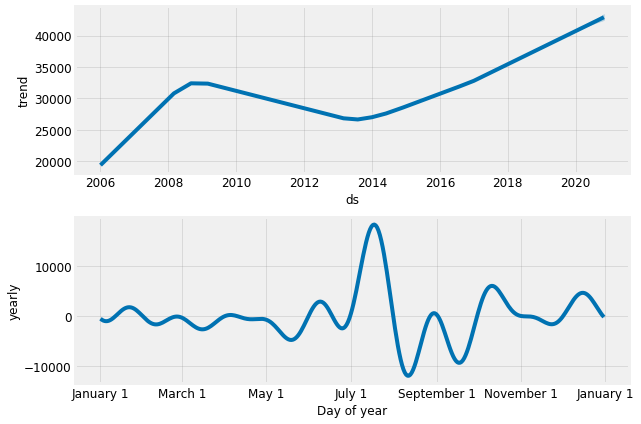

In [0]:
fig = m.plot_components(forecast)

In [0]:
forecast[["ds","yhat"]][-12:]

,ds,yhat
167,2019-12-01,40102.073258
168,2020-01-01,40355.839376
169,2020-02-01,40970.738322
170,2020-03-01,40750.188737
171,2020-04-01,41372.181918
172,2020-05-01,40785.449061
173,2020-06-01,42271.282216
174,2020-07-01,42676.935497
175,2020-08-01,41083.720885
176,2020-09-01,42709.681507
